In [41]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils.init import *

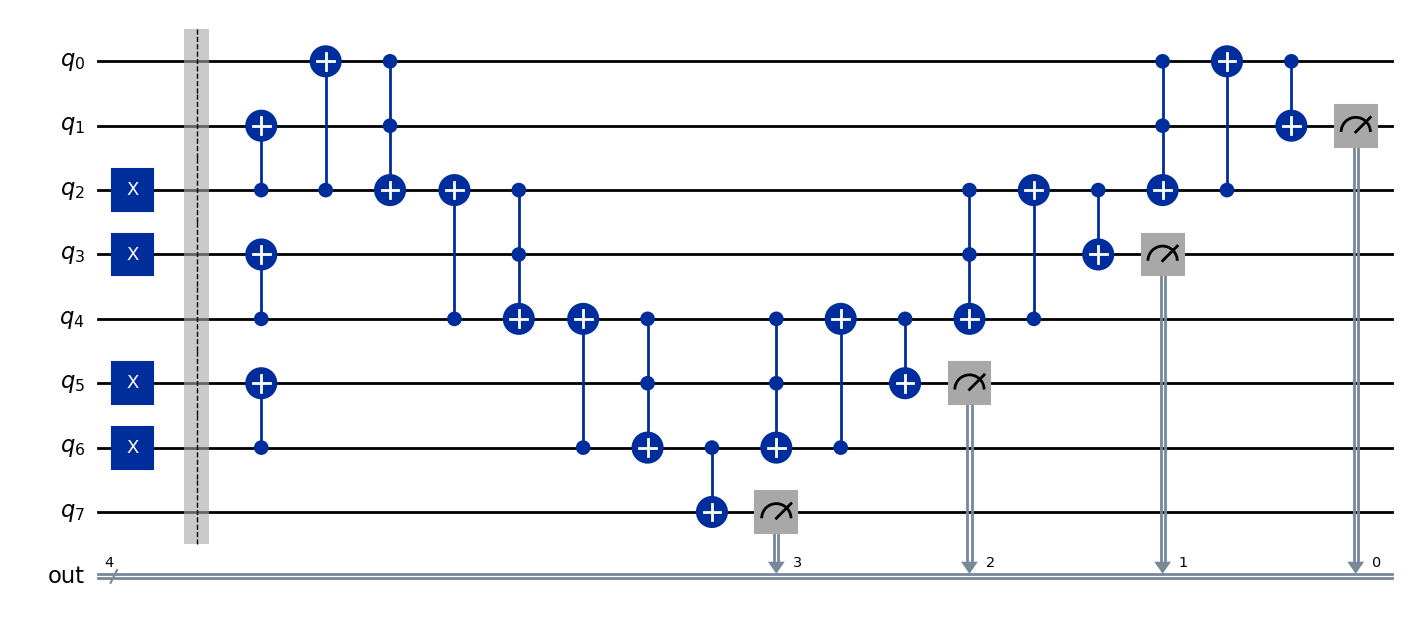

In [42]:
input_digits = 3

# 回路のビット数は入力の桁数x2 + 2（補助ビット）
circuit_width = 2 * input_digits + 2
qreg = QuantumRegister(circuit_width, name='q')
# 足し算の結果が書かれるビットのみ測定するので、出力の古典レジスタは4桁
creg = ClassicalRegister(input_digits + 1, name='out')
circuit = QuantumCircuit(qreg, creg)

# 入力の状態(a=5, b=6)をXゲートを使って設定
##################
### EDIT BELOW ###
##################

a = 5
b = 6
for iq in [x for index, x in enumerate(qreg[:-1]) if (index%2==1 and (b>>((index - 1)//2))&0b1) or (index !=0 and index%2==0 and (a>>(index//2 - 1))&0b1)]:
    circuit.x(iq)

##################
### EDIT ABOVE ###
##################

circuit.barrier()

# Uを qlow, qlow+1, qlow+2 に対して作用させる。range(0, n, 2)によってqlowの値は一つ飛ばしで与えられる
for qlow in range(0, circuit_width - 2, 2):
    ##################
    ### EDIT BELOW ###
    ##################

    # Uを実装
    circuit.cx(qlow+2, qlow+1)
    circuit.cx(qlow+2, qlow)
    circuit.ccx(qlow, qlow+1, qlow+2)

    ##################
    ### EDIT ABOVE ###
    ##################

circuit.cx(circuit_width - 2, circuit_width - 1)

# Vを qlow, qlow+1, qlow+2 に対して作用させる。range(n-1, -1, -2)によってqlowの値は一つ飛ばしで与えられる
for qlow in range(circuit_width - 4, -1, -2):
    ##################
    ### EDIT BELOW ###
    ##################

    # Vを実装
    circuit.ccx(qlow, qlow+1, qlow+2)
    circuit.cx(qlow+2, qlow)
    circuit.cx(qlow, qlow+1)

    ##################
    ### EDIT ABOVE ###
    ##################

# [1, 3, ...]量子ビットを測定し、古典レジスタに書き出す
circuit.measure(range(1, circuit_width, 2), creg)

circuit.draw('mpl')

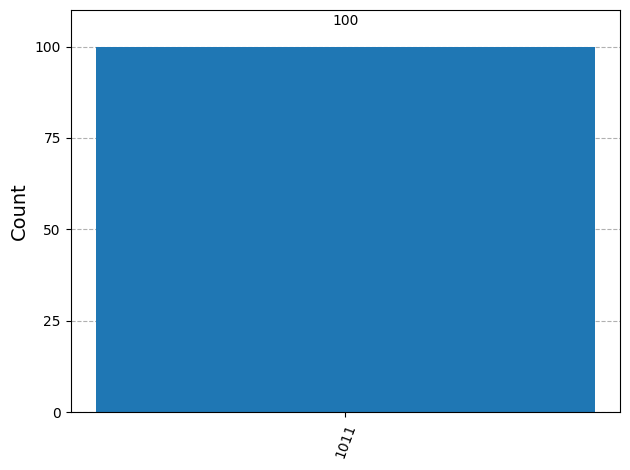

In [43]:
# シミュレータで回路を実行
simulator = AerSimulator()
sampler = LocalSampler()
shots = 100

circuit = transpile(circuit, backend=simulator)
job_result = sampler.run([circuit], shots=shots).result()
counts = job_result[0].data.out.get_counts()

plot_histogram(counts)

In [106]:
# データレジスタのビット数
data_width = 6

# 状態|ψ>を作る回路
upsi = QuantumCircuit(data_width, name='psi')
upsi.x(0)
upsi.h(2)
upsi.cx(2, 3)
for itarg in range(data_width - 1, -1, -1):
    upsi.h(itarg)
    for ictrl in range(itarg - 1, -1, -1):
        power = ictrl - itarg - 1 + data_width
        upsi.cp((2 ** power) * 2. * np.pi / (2 ** data_width), ictrl, itarg)

for iq in range(data_width // 2):
    upsi.swap(iq, data_width - 1 - iq)

In [107]:
upsi_gate = upsi.to_gate()
cupsi_gate = upsi_gate.control(1)

In [ ]:
def make_cukinv_gate(k):
    uk = QuantumCircuit(data_width, name=f'u_{k}')

    # # kの２進数表現を得るために、unpackbitsを利用（他にもいろいろな方法がある）
    # # unpackbitsはuint8タイプのアレイを引数に取るので、jをその形に変換してから渡している
    # k_bits = np.unpackbits(np.asarray(k, dtype=np.uint8), bitorder='little')
    # # k_bitsアレイのうち、ビットが立っているインデックスを得て、それらにXゲートをかける
    # for idx in np.nonzero(k_bits)[0]:
    #     uk.x(idx)

    # ビット順（LSB, MSB）がずれている
    # 回路 upsi の最後で QFT 由来の SWAP が入っている
    # 物理量子ビット 0 と 5 が入れ替わるため、シミュレータで得られる statevector_truth はビット反転順。しかし後段で作る Uk^−1 はビットを反転せずに X を打つので、同定した係数は crev(k) になってしまう。
    # by chat gpt https://chatgpt.com/c/680f7c5d-34bc-8009-94e4-e3775e61a2b2
    for bit_pos in range(data_width):
        if (k >> bit_pos) & 1:
            # ← ここでビット位置を反転して X を置く
            uk.x(data_width - 1 - bit_pos)

    # 形式上逆回路を作るが、Xの逆操作はXなので、実は全く同一の回路
    ukinv = uk.inverse()

    ukinv_gate = ukinv.to_gate()
    cukinv_gate = ukinv_gate.control(1)

    return cukinv_gate

In [109]:
reg_data = QuantumRegister(data_width, name='data')
reg_test = QuantumRegister(1, name='test')
creg_test = ClassicalRegister(1, name='out')

# 実部用と虚部用の回路をそれぞれリストに入れ、一度にシミュレータに渡す
circuits_re = []
circuits_im = []

ks = np.arange(2 ** data_width)

for k in ks:
    circuit_re = QuantumCircuit(reg_data, reg_test, creg_test)
    circuit_im = QuantumCircuit(reg_data, reg_test, creg_test)

    ##################
    ### EDIT BELOW ###
    ##################

    # 制御ゲートをcircuitに組み込む例
    # circuit.append(cupsi_gate, qargs=([reg_test[0]] + reg_data[:]))

    # ------------------ 実部 ------------------
    circuit_re.h(reg_test[0])
    circuit_re.append(cupsi_gate, qargs=([reg_test[0]] + reg_data[:]))
    circuit_re.append(make_cukinv_gate(k), qargs=([reg_test[0]] + reg_data[:]))
    circuit_re.h(reg_test[0])

    # ------------------ 虚部 ------------------
    circuit_im.rx(np.pi/2, reg_test[0])
    circuit_im.append(cupsi_gate, qargs=([reg_test[0]] + reg_data[:]))
    circuit_im.append(make_cukinv_gate(k), qargs=([reg_test[0]] + reg_data[:]))
    circuit_im.h(reg_test[0])

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit_re.measure(reg_test, creg_test)
    circuit_im.measure(reg_test, creg_test)

    circuits_re.append(circuit_re)
    circuits_im.append(circuit_im)

# シミュレータで回路を実行
simulator = AerSimulator()
sampler = LocalSampler()
shots = 10000

circuits_re = transpile(circuits_re, backend=simulator)
circuits_im = transpile(circuits_im, backend=simulator)

job_result_re = sampler.run(circuits_re, shots=shots).result()
job_result_im = sampler.run(circuits_im, shots=shots).result()

# 状態ベクトルアレイ
statevector = np.empty(2 ** data_width, dtype=np.complex128)

for k in ks:
    counts_re = job_result_re[k].data.out.get_counts()
    counts_im = job_result_im[k].data.out.get_counts()
    statevector[k] = (counts_re.get('0', 0) - counts_re.get('1', 0)) / shots
    statevector[k] += 1.j * (counts_im.get('0', 0) - counts_im.get('1', 0)) / shots


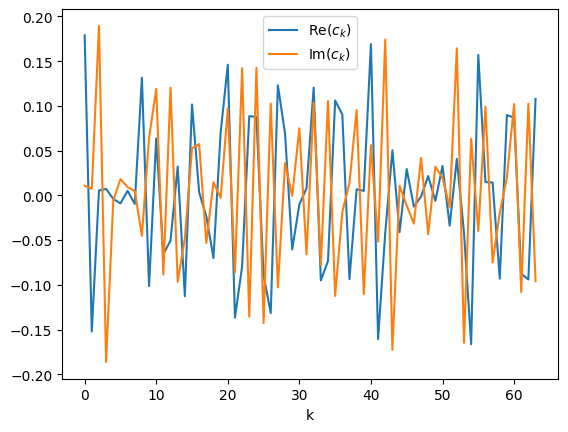

In [110]:
plt.plot(ks, statevector.real, label='Re($c_k$)')
plt.plot(ks, statevector.imag, label='Im($c_k$)')
plt.xlabel('k')
plt.legend()

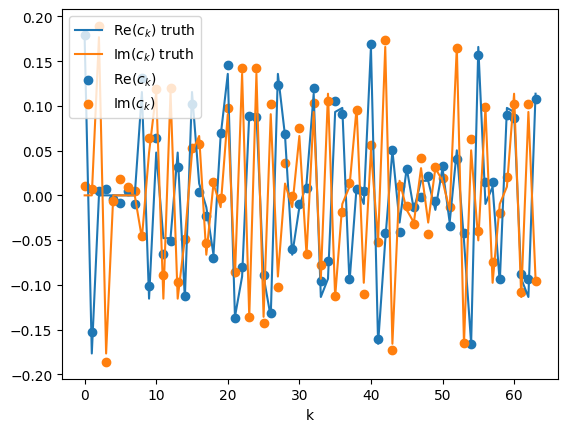

In [111]:
sv_simulator = AerSimulator(method='statevector')

# save_statevectorをくっつけるので元の回路をコピーする
circuit = upsi.copy()
circuit.save_statevector()

circuit = transpile(circuit, backend=sv_simulator)
statevector_truth = np.asarray(sv_simulator.run(circuit).result().data()['statevector'])

plt.plot(ks, statevector_truth.real, label='Re($c_k$) truth')
plt.plot(ks, statevector_truth.imag, label='Im($c_k$) truth')
plt.scatter(ks, statevector.real, label='Re($c_k$)')
plt.scatter(ks, statevector.imag, label='Im($c_k$)')
plt.xlabel('k')
plt.legend()

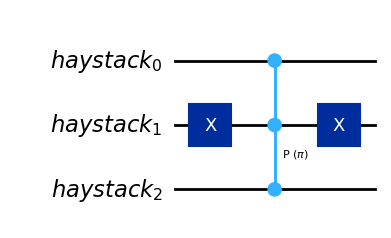

In [112]:
num_qubits = 3
needle = 5

haystack_register = QuantumRegister(num_qubits, name='haystack') # ビット数を指定してレジスタを作る
blackbox_circuit = QuantumCircuit(haystack_register, name='blackbox') # レジスタから回路を作る

# unpackbitsでneedleが二進数のビット列に変換される。それを1から引くことでビット反転
needle_bits = 1 - np.unpackbits(np.asarray(needle, dtype=np.uint8), bitorder='little')[:num_qubits]
for idx in np.nonzero(needle_bits)[0]:
    blackbox_circuit.x(haystack_register[idx])

# レジスタの（0番から）最後から二番目のビットまでで制御し、最後のビットを標的にする
blackbox_circuit.mcp(np.pi, haystack_register[:-1], haystack_register[-1])

# 後片付け
for idx in np.nonzero(needle_bits)[0]:
    blackbox_circuit.x(haystack_register[idx])

blackbox_circuit.draw('mpl')

In [113]:
# blackbox_circuitを3量子ビットゲート化
blackbox = blackbox_circuit.to_gate()
# さらにblackboxゲートを1制御+3標的ビットゲート化
cblackbox = blackbox.control(1)

In [145]:
def make_haystack_needle():
    test_register = QuantumRegister(1, 'test')
    circuit = QuantumCircuit(haystack_register, test_register)

    # equal superpositionを作る（このようにゲート操作のメソッドにレジスタを渡すと、レジスタの各ビットにゲートがかかります。）
    circuit.h(haystack_register)

    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?
    circuit.h(test_register[0])
    circuit.append(cblackbox, qargs=([test_register[0]] + haystack_register[:]))
    circuit.h(test_register[0])

    ##################
    ### EDIT ABOVE ###
    ##################

    circuit.measure_all()

    return circuit

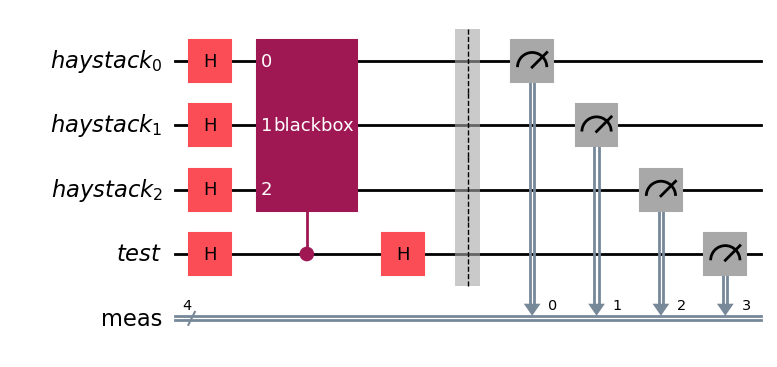

In [146]:
haystack_needle = make_haystack_needle()
haystack_needle.draw('mpl')

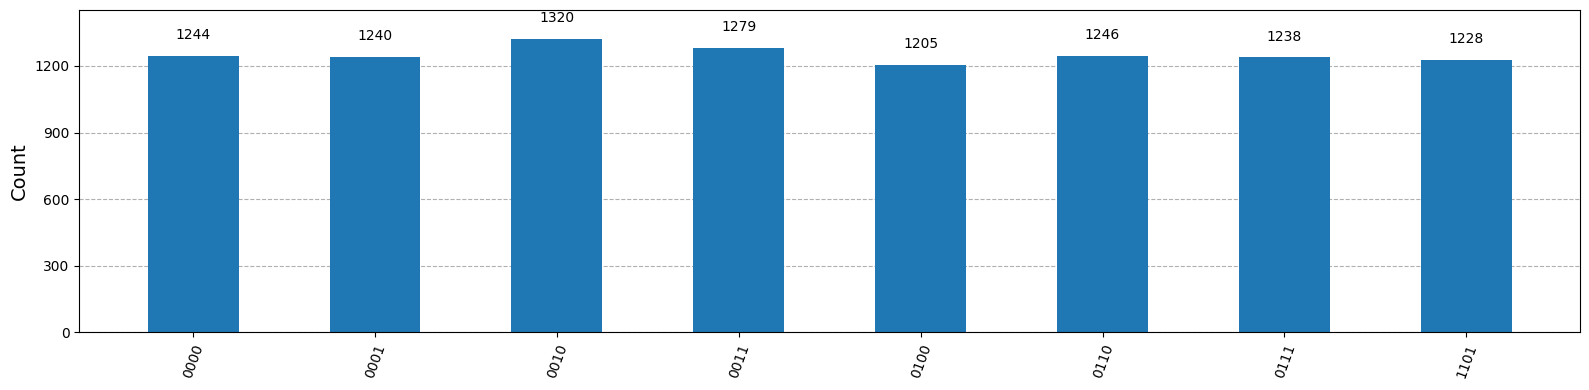

In [147]:
simulator = AerSimulator()
sampler = LocalSampler()
haystack_needle = transpile(haystack_needle, backend=simulator)
counts = sampler.run([haystack_needle], shots=10000).result()[0].data.meas.get_counts()
plot_histogram(counts, figsize=(16, 4))